In [1]:
import comet_ml
import os
import sys
from joblib import dump, load
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
import pandas as pd
from sklearn.model_selection  import train_test_split
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from feature_engineering import preprocessing
from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot

In [2]:
df = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')
X, y = preprocessing (df, 'goalFlag')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
clf_1 = LogisticRegression(penalty= 'elasticnet', max_iter= 1000, solver= 'saga', l1_ratio= 0.5).fit(X_train, y_train)

In [4]:
y_score = clf_1.predict_proba(X_test)

AUC metric : 0.7375698648542831


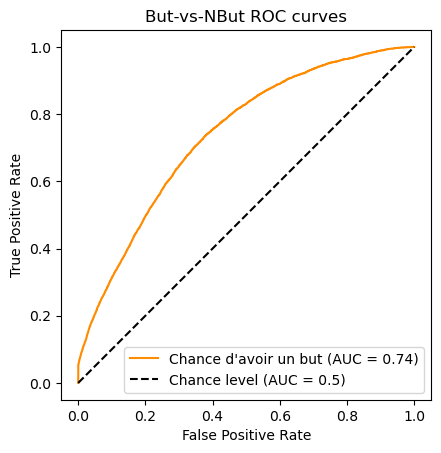

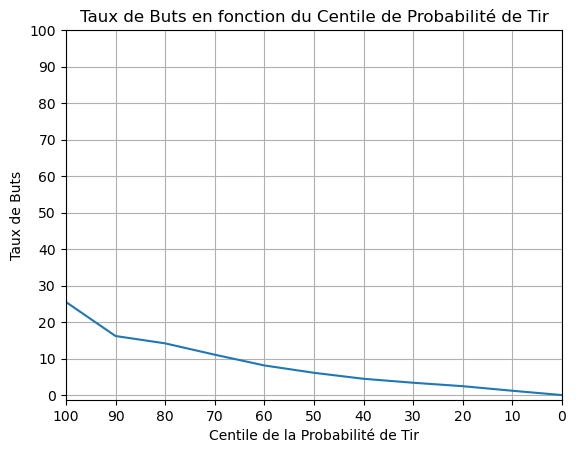

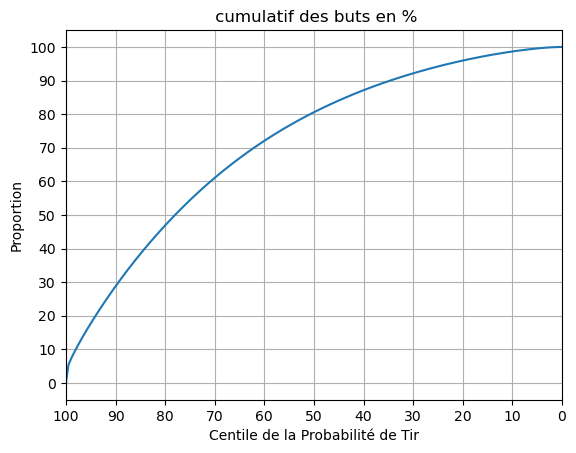

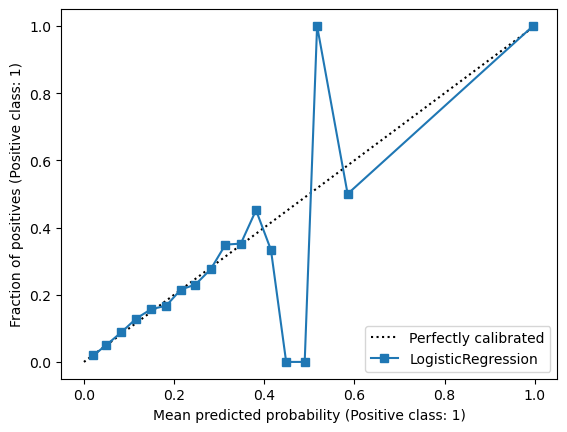

In [5]:
# on s'intéresse à la deuxième colonne y_score[:,1] qui représente la probabilité de prédire un but

# Receiver Operating Characteristic
ROC_plot(y_test, y_score[:,1])

# Taux de buts
Centiles_plot(pd.Series(y_test), y_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y_test, y_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf_1,X_test, y_test, n_bins=30)

In [ ]:
xgb_model = XGBClassifier(base_estimator=LogisticRegression(penalty= 'elasticnet', max_iter= 1000, solver= 'saga', l1_ratio= 0.5), random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6],
}

random_sch = RandomizedSearchCV(xgb_model, param_grid, refit=True, n_iter=10, n_jobs=-1)
#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
# Train the XGBoost model
random_sch.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_sch.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions with the best model
best_model = random_sch.best_estimator_
predictions = best_model.predict_proba(X_test)

[01:50:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "base_estimator" } are not used.

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}


AUC metric : 0.7637284988136708


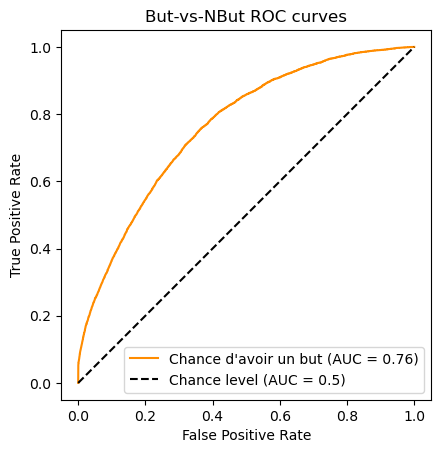

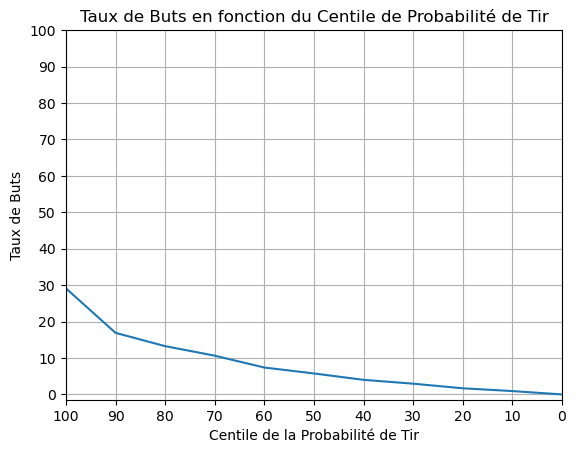

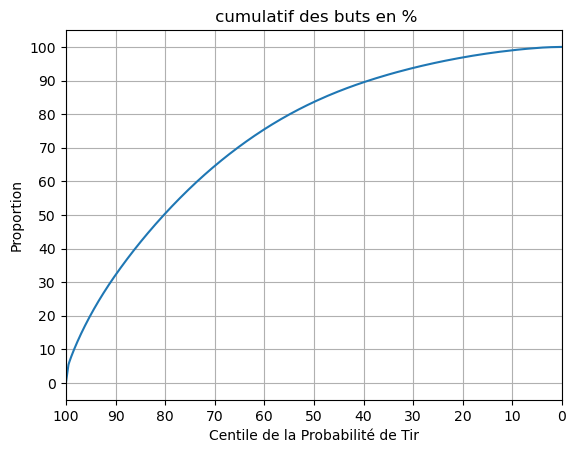

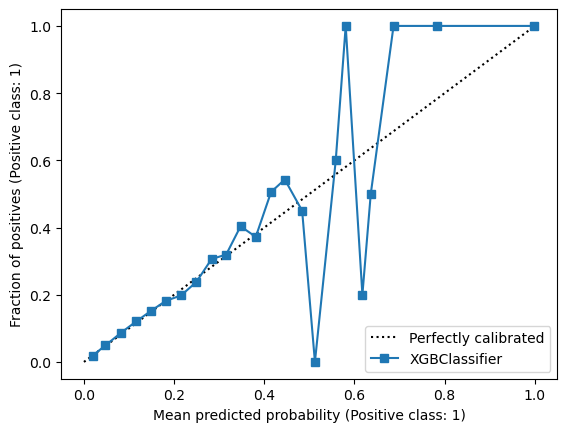

In [ ]:
# Receiver Operating Characteristic
AUC = ROC_plot(y_test, predictions[:,1])

# Taux de buts
Centiles_plot(pd.Series(y_test), predictions[:,1])

# Cumule de buts
cumulative_centiles_plot(y_test, predictions[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(best_model,X_test, y_test, n_bins=30)

In [6]:
saved_model = load('../models/XGB_XGB_Logistic_reg.joblib')

In [7]:
best_predictions = saved_model.predict_proba(X_test)

AUC metric : 0.7641846425957022


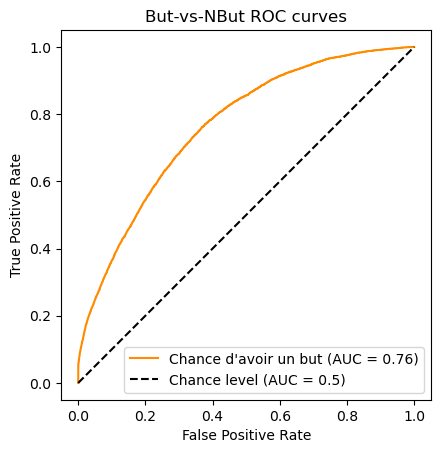

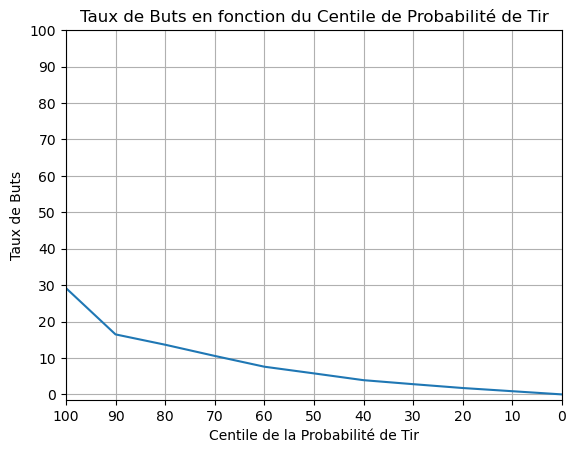

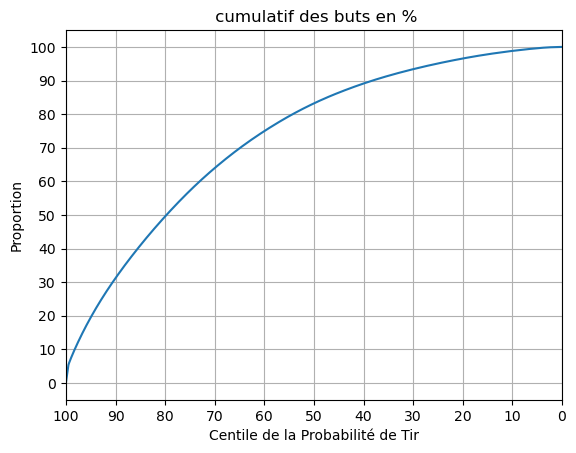

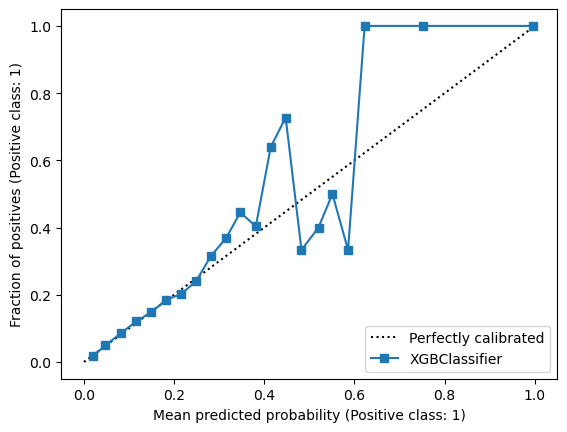

In [8]:
# Receiver Operating Characteristic
AUC = ROC_plot(y_test, best_predictions[:,1])

# Taux de buts
Centiles_plot(pd.Series(y_test), best_predictions[:,1])

# Cumule de buts
cumulative_centiles_plot(y_test, best_predictions[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(saved_model,X_test, y_test, n_bins=30)

In [14]:
experiment_5 = comet_ml.Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='Milestone_2',
    workspace= 'me-pic'
    )

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data [count]:
COMET INFO:     display_summary_level [2] : 1
COMET INFO:     url [2]                   : https://www.comet.com/me-pic/milestone-2/597056a786024a58813bc8e10412a766
COMET INFO:   Metrics:
COMET INFO:     AUC : 0.7641846425957022
COMET INFO:   Others:
COMET INFO:     Name : XGB_Logistic_reg2
COMET INFO:   Parameters:
COMET INFO:     base_estimator          : LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')
COMET INFO:     base_score              : 1
COMET INFO:     booster                 : 1
COMET INFO:     callbacks               : 1
COMET INFO:     colsample_bylevel       : 1
COMET INFO:     colsample_bynode        : 1
COMET INFO:     colsample_bytree        : 1
COMET INFO:     early_stopping_rounds   : 1
COMET INFO:     enable_categorical      : 1
COMET INFO:     eval_metric          

In [15]:

#save model


dump(best_model, '../models/XGB_XGB_Logistic_reg.joblib')

['../models/XGB_XGB_Logistic_reg.joblib']

In [10]:
Best_params = saved_model.get_params()

In [15]:
experiment_5.set_name("XGB_Logistic_reg2")

#Log parameters and metrics

experiment_5.log_parameters(Best_params)
experiment_5.log_metrics({"AUC":AUC})
#Log model and end experiment

experiment_5.log_model('XGB_Logistic_reg', '../models/XGB_XGB_Logistic_reg.joblib')
#experiment.log_model('neuron', '../neuron.joblib')



{'web': 'https://www.comet.com/api/asset/download?assetId=93ff3d573dd145c293c6c71dfef69595&experimentKey=b262169dba0a46bb86d3ce2c9222bfa7',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=93ff3d573dd145c293c6c71dfef69595&experimentKey=b262169dba0a46bb86d3ce2c9222bfa7',
 'assetId': '93ff3d573dd145c293c6c71dfef69595'}

In [16]:
#End experiment

experiment_5.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/me-pic/milestone-2/b262169dba0a46bb86d3ce2c9222bfa7
COMET INFO:   Metrics:
COMET INFO:     AUC : 0.7641846425957022
COMET INFO:   Others:
COMET INFO:     Name : XGB_Logistic_reg2
COMET INFO:   Parameters:
COMET INFO:     base_estimator          : LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')
COMET INFO:     base_score              : 1
COMET INFO:     booster                 : 1
COMET INFO:     callbacks               : 1
COMET INFO:     colsample_bylevel       : 1
COMET INFO:     colsample_bynode        : 1
COMET INFO:     colsample_bytree        : 1
COMET INFO:     early_stopping_rounds   : 1
COMET INFO:     enable_categorical      : 1
COMET INFO:     eval_metric             : 1
COMET INF

AttributeError: 'GPULoggingThread' object has no attribute 'isAlive'